# Νευρωνικά Δίκτυα

Παρακάτω θα παρουσιάσουμε μερικές αρχιτεκτονικές νευρωνικών δικτύων.

***

## Συναρτήσεις 

Οι παρακάτω βοηθητικές συναρτήσεις θα χρησιμοποιηθούν για να κάνουμε train και test το μοντέλο.

Αρχικά κάνουμε τα απαραίτητα imports και ορίζουμε την συσκευή που θα χρησιμοποιήσουμε (cpu/gpu).

In [184]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import pandas as pd
import os
from torch.optim import lr_scheduler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device, imports complete!'.format(device))

Using cpu device, imports complete!


Στην συνέχεια ορίζουμε την πρώτη συνάρτηση η οποία δέχεται ένα μοντέλο, το training dataset, την συνάρτηση λάθους, τον optimizer, και την συσκευή που χρησιμοποιούμε. Προχωράει το training κατά ένα βήμα και επιστρέφει την απώλεια.

In [185]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = 'cpu'):
    model.to(device)
    model.train()

    train_loss = 0
    for X_batch, y_batch in data_loader:
        # Send data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        train_loss += loss.item()
    
    return train_loss


Ομοίως η παρακάτω συνάρτηση κάνει test το μοντέλο σε κάθε εποχή, και επιστρέφει την απώλεια.

In [186]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = 'cpu'):
    model.to(device)
    model.eval()

    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in data_loader:
            # Send data to GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_test_pred = model(X_batch)
            test_loss += loss_fn(y_test_pred, y_batch).item()
    
    return test_loss

In [187]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               device: torch.device = 'cpu',
               return_all = False):
    loss = 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
        loss /= len(data_loader)
    if(return_all):
        return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item()
            }
    else:
        return loss.item()

Η βασική συνάρτηση, επαναληπτικά για όσες εποχές έχουμε διαλέξει κάνει train και test το μοντέλο, και ανά 10 εποχές εκτυπώνει τα αποτελέσματα. Επιστρέφει 2 πίνακες με τις συνολικές απώλειες σε κάθε επανάληψη.

In [188]:
def train_test_model(epoch : int, 
                     model: torch.nn.Module,
                     train_loader: torch.utils.data.DataLoader,
                     test_loader: torch.utils.data.DataLoader,
                     loss_fn: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     scheduler,
                     device: torch.device = 'cpu',
                     seed: int = 42):
    torch.manual_seed(seed)
    train_loss_arr = []
    test_loss_arr = []
    error_dist_train = []
    error_dist_test = []
    for epochs in range(epoch):
        epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
        train_loss_arr.append(epoch_loss / len(train_loader))

        scheduler.step(epoch_loss)
        after_lr = optimizer.param_groups[0]['lr']

        test_loss = test_step(model, test_loader, loss_fn, device)
        test_loss_arr.append(test_loss / len(test_loader))
        error_dist_train.append(eval_model(model,train_loader,loss_fn,device))
        error_dist_test.append(eval_model(model,train_loader,loss_fn,device))
        if (epochs) % 10 == 0 or epochs == 0:
            print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
        elif epochs + 1 == epoch:
            print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
    
    return train_loss_arr, test_loss_arr, error_dist_train, error_dist_test

Η συνάρτηση είναι παρόμοια με την test_step με την διαφορά ότι επιστρέφει ένα dictionary με τα βασικά στοιχεία του μοντέλου.

Η συνάρτηση αυτή χρησιμοποιείται για να εμφανίσει τις κανονικοποιημένες στο (0,1) train_loss και test_loss curves.

In [189]:
def plot_results(train_arr, test_arr, error_train,error_test):
    # Plot the loss curves
    if(np.max(train_arr) != np.min(train_arr)):
        train_arr = (train_arr - np.min(train_arr)) / (np.max(train_arr) - np.min(train_arr))
    else:
        print("Min and max of train array are the same")
        print(train_arr)
        return
    if(np.max(test_arr) != np.min(test_arr)):
        test_arr = (test_arr - np.min(test_arr)) / (np.max(test_arr) - np.min(test_arr))
    else:
        print("Min and Max of test array are the same")
        print(test_arr)
        return
    # plt.figure(figsize=(8, 5))
    # plt.plot(train_arr, label='Train Loss')
    # plt.plot(test_arr, label='Test Loss')
    # plt.xlabel("Epochs")
    # plt.ylabel("Normalized Loss")
    # plt.title("Normalized Training Loss")
    # plt.grid()
    # plt.legend()
    # plt.show()


    lin = np.linspace(0,1,len(train_arr))

    axis1 = plt.subplot(211)
    axis2 = plt.subplot(212)
    axis1.plot(lin,train_arr,color='red',label = 'Train loss')
    axis1.plot(lin,test_arr,color='blue',label="Test loss")
    axis1.set_xlabel('epochs')
    axis1.set_ylabel('Normalized loss')
    axis1.set_title('Train and test loss per epoch')
    axis1.legend()
    axis1.grid(True)
    
    axis2.plot(lin,error_test,color='red',label = 'Train error')
    axis2.plot(lin,error_test,color='blue',label="Test error")
    axis2.set_xlabel('epochs')
    axis2.set_ylabel('error')
    axis2.set_title('Train and test error per epoch')
    axis2.legend()
    axis2.grid(True)
    
    plt.tight_layout()
    plt.show()

***

## Εισαγωγή δεδομένων

Η συνάρτηση αυτή δέχεται τα paths των δεδομένων, δημιουργεί και επιστρέφει τα mini_batches που θα χρησιμοποιηθούν στο training.

ΣΟΣ Να αλλάξουμε το scaling method

In [190]:
def data_func(input_array, labels, batch_size = 32, test_size = 0.2):
    # Reshape the tensor to 2D so that it can be used in the linear model
    X = input_array.reshape(len(input_array), -1)
    y = labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    
    scaler = StandardScaler()
    # Fit the scaler on the training data and transform both the training and test sets
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Transform the data to PyTorch tensors and move them to the GPU if available
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Define the dataset
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    # Define the data loader
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader

Ανάλογα με τον ποιον φάκελο θέλουμε να διαβάσουμε αλλάζουμε το νουμεράκι.

In [191]:
# Define the pickle file name and relative path
pickle_name = "Sim_Data_Noisy_Interp.pkl"
folder_name = "Sim_Data_0"  # Change accordingly

relative_path = os.path.join("..", "Simulation", folder_name, pickle_name)

# Resolve the absolute path
file_path = os.path.abspath(relative_path)

try:
    # Check if the file exists before attempting to read
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    # Load the pickle file
    df = pd.read_pickle(file_path)
except Exception as e:
    print(f"An unexpected error occurred: {e}")

df.head()


,tag_pos,Antenna,robot_pos,Phases
0,"[1.3374070790110344, 0.1, 0.1]",[0],"[0.6625929209889657, 0.6661549086159794, 0.669...","[0.0, -0.10487150506512838, -0.221901548402660..."
1,"[1.9494820917610742, 0.1, 0.1]",[0],"[0.05051790823892587, 0.054072937717603915, 0....","[0.0, -0.10101337624334959, -0.321809004322664..."
2,"[0.4116242295452528, 0.1, 0.1]",[0],"[1.5883757704547472, 1.5920683760992664, 1.595...","[0.0, -0.13453695823921752, -0.255845581716036..."
3,"[1.2026705067177903, 0.1, 0.1]",[0],"[0.7973294932822097, 0.80090229956099, 0.80447...","[0.0, -0.14502076970326194, -0.377630922159475..."
4,"[1.4467800565600593, 0.1, 0.1]",[0],"[0.5532199434399407, 0.5567733429395528, 0.560...","[0.0, -0.12889416459989012, -0.239887498367972..."


Δημιουργούμε τα training και testing sets.

In [192]:
rfid_label = np.array(df['tag_pos'].tolist())[:, :2] 
rfid_label.shape

(10000, 2)

In [193]:
# Convert columns to NumPy arrays
robot_pos_array = np.stack(df["robot_pos"].to_numpy())  # Shape: (10000, 400)
phases_array = np.stack(df["Phases"].to_numpy())  # Shape: (10000, 400)

# Concatenate along the last axis
info_tensor = np.stack((robot_pos_array, phases_array), axis=-1)  # Shape: (10000, 400, 2)
info_tensor.shape

(10000, 400, 2)

Ουσιαστικά αναζητούμε τα **Χ και Υ** του RFID TAG, γνωρίζοντας το πως κινήθηκε κατά τον άξονα **Χ** και την μέτρηση της **φάσης** του.

In [194]:
train_loader, test_loader = data_func(info_tensor, rfid_label)

In [195]:
len(train_loader) # Should be (total_tags / batch_size) * train_partition 

250

Αποθηκεύουμε σε μεταβλητές τα μεγέθη του input και του output για τα γραμμικά μοντέλα.

In [196]:
output_len = rfid_label.shape[1]
input_len = info_tensor.shape[1] * info_tensor.shape[2]

input_len,output_len

(800, 2)

***

## Φακελοποίηση και αποθήκευση μοντέλων

In [197]:
from pathlib import Path

# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

# Initialize a list to store the indices
existing_indices = []

# Iterate through the folders in the directory
for folder in parent_dir.iterdir():
    if folder.is_dir() and folder.name.startswith("NN_Data_"):  # Check if it's a directory and follows the pattern
        try:
            index = int(folder.name[len("NN_Data_"):])  # Extract the number part
            existing_indices.append(index)
        except ValueError:
            pass  # Ignore folders that don't have a valid integer index

# Determine the next index
new_index = (max(existing_indices) + 1) if existing_indices else 0

# Create the new folder
new_folder_path = parent_dir / f"NN_Data_{new_index}"
new_folder_path.mkdir(exist_ok=True)

print(f"Created folder: {new_folder_path}")

Created folder: c:\Users\giama\Desktop\ece_auth\semester10\NNs-on-RFID-Localization\Neural_Networks\NN_Data_1


In [198]:

def save_model_info(model:nn.Module,filename):
    p = Path(f"{filename}.pt")
    torch.save(model.state_dict(),p)

def load_model_info(model,filename):
    if not isinstance(filename,Path):
        p = Path(filename)
        if(p.exists()):
            model.load_state_dict(torch.load(p))
        else:
            print(f"{filename} doesn't exist")
    else:
        model.load_state_dict(torch.load(filename,map_location=device))
    return model

## Αρχιτεκτονικές

### Αρχιτεκτονική 1

Το πρώτο μας μοντέλο θα είναι η απλούστερη περίπτωση ενός γραμμικού layer με είσοδο το ```input_size``` δηλαδή 4000 (για την ώρα) , και έξοδο 2 (x,y), χωρίς για αρχή κάποια συνάρτηση ενεργοποίησης.

Σαν συνάρτηση λάθους θα χρησιμοποιηθεί η ```MSELoss``` ενώ σαν optimizers θα δοκιμαστούν οι ```Adam```, ```RMSProp```, ```SGD```.

In [199]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= output_size),  
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 2.442991736769676 | Loss test: 1.7589894485852076 | lr = 0.01
Epoch 10 | Loss train: 0.7018633679747581 | Loss test: 2.0535765829540433 | lr = 0.01
Epoch 20 | Loss train: 0.7315546288490296 | Loss test: 1.149151013011024 | lr = 0.01
Epoch 30 | Loss train: 0.2848907336294651 | Loss test: 0.3184306876999991 | lr = 0.001
Epoch 40 | Loss train: 0.24904067793488502 | Loss test: 0.2568103839007635 | lr = 0.0001
Epoch 50 | Loss train: 0.2484820350110531 | Loss test: 0.2528519883515343 | lr = 0.0001
Epoch 60 | Loss train: 0.24395661810040473 | Loss test: 0.24665712080304586 | lr = 1e-05
Epoch 70 | Loss train: 0.24368324109911918 | Loss test: 0.2470890243375112 | lr = 1e-05
Epoch 80 | Loss train: 0.2436762080192566 | Loss test: 0.24606461231670682 | lr = 1.0000000000000002e-06
Epoch 90 | Loss train: 0.24346683531999588 | Loss test: 0.24620042883214496 | lr = 1.0000000000000002e-06
Epoch 100 | Loss train: 0.2434399429857731 | Loss test: 0.2463193197572042 | lr = 1.000000000

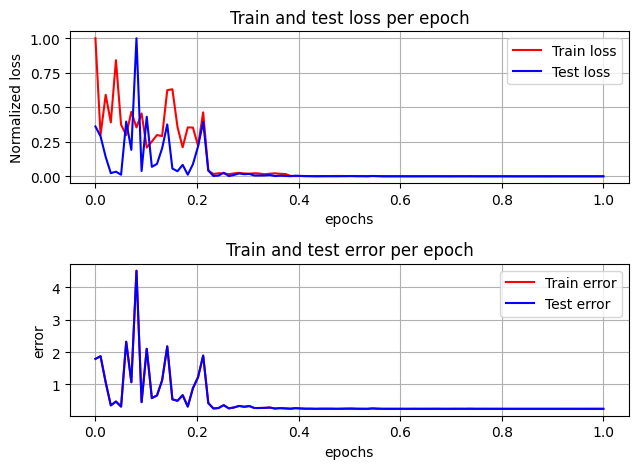

In [200]:
# Instantiate the model
model_0 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

train_loss, test_loss, train_err, test_err = train_test_model(epoch = 100,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(train_loss, test_loss,train_err,test_err)

Χρησιμοποιήσαμε τον optimizer ``` Adam ``` τώρα θα χρησιμοποιήσουμε τον ``` RMSProp```

Epoch 0 | Loss train: 67.0755562567711 | Loss test: 11.015262755136641 | lr = 0.01
Epoch 10 | Loss train: 16.269806262016296 | Loss test: 9.034946926056392 | lr = 0.01
Epoch 20 | Loss train: 18.817136261463165 | Loss test: 2.6029304114599077 | lr = 0.01
Epoch 30 | Loss train: 0.421134985268116 | Loss test: 0.525371475825234 | lr = 0.001
Epoch 40 | Loss train: 0.25275802341103554 | Loss test: 0.2515630703123789 | lr = 0.0001
Epoch 50 | Loss train: 0.25294512739777564 | Loss test: 0.25100036887895494 | lr = 0.0001
Epoch 60 | Loss train: 0.2532668907642365 | Loss test: 0.2500048490270736 | lr = 0.0001
Epoch 70 | Loss train: 0.25329377377033235 | Loss test: 0.2509333154275304 | lr = 0.0001
Epoch 80 | Loss train: 0.24679232206940652 | Loss test: 0.24794032720346298 | lr = 1e-05
Epoch 90 | Loss train: 0.24745686295628547 | Loss test: 0.24837689314569747 | lr = 1e-05
Epoch 100 | Loss train: 0.2464731511771679 | Loss test: 0.2479326646952402 | lr = 1.0000000000000002e-06


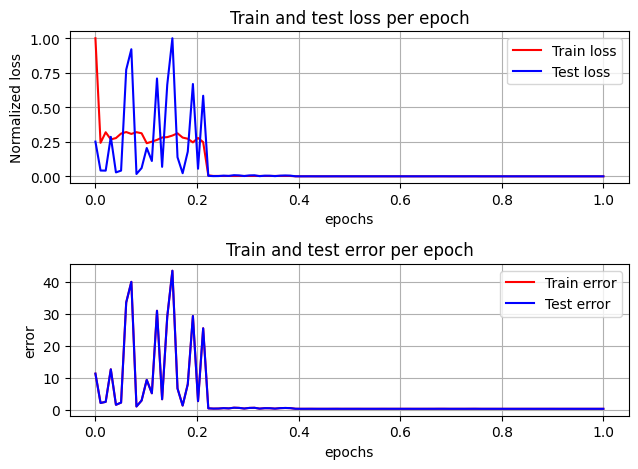

In [156]:
# Instantiate the model
model_1 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(model_1.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

train_loss, test_loss, train_err, test_err = train_test_model(epoch = 100,model = model_1, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(train_loss, test_loss,train_err,test_err)

Και τέλος χρησιμοποιούμε και τον ``` SGD ```

Epoch 0 | Loss train: 0.6985769748091698 | Loss test: 0.2968014906796198 | lr = 0.01
Epoch 10 | Loss train: 0.37838746279478075 | Loss test: 0.5268244393288143 | lr = 0.01
Epoch 20 | Loss train: 0.39693451860547063 | Loss test: 0.4806141344800828 | lr = 0.01
Epoch 30 | Loss train: 0.2565012172460556 | Loss test: 0.2465363937237906 | lr = 0.001
Epoch 40 | Loss train: 0.2616199341714382 | Loss test: 0.2772587239742279 | lr = 0.001
Epoch 50 | Loss train: 0.25871525579690935 | Loss test: 0.24763569850770253 | lr = 0.001
Epoch 60 | Loss train: 0.2457088907957077 | Loss test: 0.24686961538261837 | lr = 0.0001
Epoch 70 | Loss train: 0.2438732275366783 | Loss test: 0.24593697701181685 | lr = 1e-05
Epoch 80 | Loss train: 0.24398812428116798 | Loss test: 0.2457136722311141 | lr = 1e-05
Epoch 90 | Loss train: 0.24388027331233025 | Loss test: 0.24580813636855472 | lr = 1.0000000000000002e-06
Epoch 100 | Loss train: 0.2438784010708332 | Loss test: 0.24586264268746452 | lr = 1.0000000000000002e-07


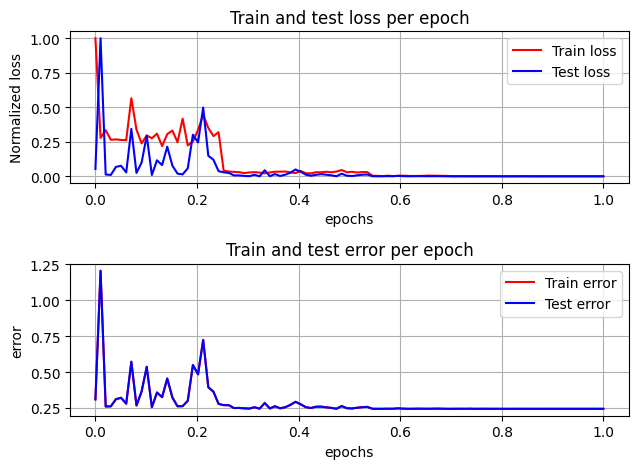

In [157]:
# Instantiate the model
model_2 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=learning_rate, momentum= 0.9)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

train_loss, test_loss, train_err, test_err = train_test_model(epoch = 100,model = model_2, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(train_loss, test_loss,train_err,test_err)

Έχοντας προπονήσει τα μοντέλα για 100 εποχές με διαφορετικούς optimizers παρατηρούμε ότι η καλύτερη απόδοση έιναι από τον ``` Adam ``` ο οποίος θα χρησιμοποιηθεί και μετέπειτα.

***

### Αρχιτεκτονική 2

#### ReLU 128

Το δεύτερο μοντέλο μας θα αποκτήσει άλλα 2 layers δίνοντας μας την δυνατότητα θεωρητικά να πετύχουμε μικρότερη απώλεια συγκριτικά με την απλούστερη περίπτωση. Επιπλέον μας δίνεται η δυνατότητα να μεταβάλλουμε τόσο την μεταβλητή ```hidden_units``` που καθορίζει το μέγεθος των ενδιάμεσων επιπέδων, όσο και τις συναρτήσεις ενεργοποίησης.

Για αρχή επιλέγουμε την συνηθέστερη επιλογή την συνάρτηση ``` ReLU```, ο τύπος της οποίας δίνεται παρακάτω.

$ReLU(x) = max(0,x)$

In [201]:
# Build the model

class ReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(ReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 1.3434245580285789 | Loss test: 0.12303697690367699 | lr = 0.01
Epoch 10 | Loss train: 0.029550498366355895 | Loss test: 0.033983474449505884 | lr = 0.01
Epoch 20 | Loss train: 0.020408293135464193 | Loss test: 0.019909326534067826 | lr = 0.01
Epoch 30 | Loss train: 0.018105446370318534 | Loss test: 0.011176851858931875 | lr = 0.01
Epoch 40 | Loss train: 0.016066455265507103 | Loss test: 0.01649510171560068 | lr = 0.01
Epoch 50 | Loss train: 0.01955512651242316 | Loss test: 0.021629446422651646 | lr = 0.01
Epoch 60 | Loss train: 0.012160894921049476 | Loss test: 0.011901794681473383 | lr = 0.01
Epoch 70 | Loss train: 0.012817980902269483 | Loss test: 0.016073888034692833 | lr = 0.01
Epoch 80 | Loss train: 0.011341091811656951 | Loss test: 0.009422889918029781 | lr = 0.01
Epoch 90 | Loss train: 0.009990536788478494 | Loss test: 0.012028184216765185 | lr = 0.01
Epoch 100 | Loss train: 0.01122888067830354 | Loss test: 0.019289893615576956 | lr = 0.01


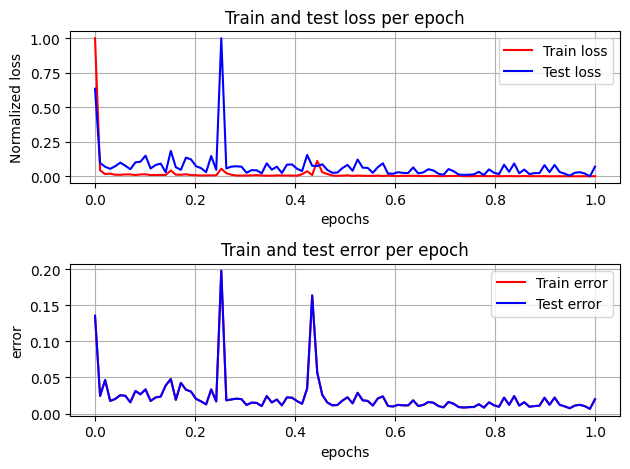

In [203]:
# Instantiate the model
model_3 = ReLUModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

train_loss, test_loss, train_err, test_err = train_test_model(epoch = 100,model = model_3, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(train_loss, test_loss,train_err,test_err)

relu_model = eval_model(model_3, test_loader, loss_fn, device,True)
save_model_info(model_3,os.path.join(new_folder_path,relu_model["model_name"]))

In [160]:
relu_model

{'model_name': 'ReLUModel', 'model_loss': 0.004468351602554321}

Ήδη τα αποτελέσματα είναι πολύ καλύτερα συγκριτικά με την προηγούμενη αρχιτεκτονική.

#### ReLU 256

Τώρα θα αυξήσουμε τον αριθμό των ```hidden_units```  από 128 σε 256 για να δούμε κάποια πιθανή διαφορά.

In [ ]:
# Instantiate the model
model_4 = ReLUModel(input_size=input_len, output_size=output_len, hidden_units= 256)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

train_loss, test_loss, train_err, test_err = train_test_model(epoch = 100,model = model_4, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(train_loss, test_loss,train_err,test_err)

relu_model_256 = eval_model(model_4, test_loader, loss_fn, device,True)
save_model_info(model_4,os.path.join(new_folder_path,relu_model_256["model_name"]))

Epoch 0 | Loss train: 3.5083673891127107 | Loss test: 0.18004838034274087 | lr = 0.01


KeyboardInterrupt: 

In [162]:
relu_model_256, relu_model

({'model_name': 'ReLUModel', 'model_loss': 0.003962622955441475},
 {'model_name': 'ReLUModel', 'model_loss': 0.004468351602554321})

#### ReLU 64

Τα αποτελέσματα με 128 hidden units είναι καλύτερα, δοκιμάζουμε τέλος με 64.

Epoch 0 | Loss train: 0.6839613058716059 | Loss test: 0.08295446108021433 | lr = 0.01
Epoch 10 | Loss train: 0.018889832451939582 | Loss test: 0.015706334085691543 | lr = 0.01
Epoch 20 | Loss train: 0.014083020327612758 | Loss test: 0.020804466117942143 | lr = 0.01
Epoch 30 | Loss train: 0.007594349544495344 | Loss test: 0.0053658033240704785 | lr = 0.001
Epoch 40 | Loss train: 0.004969080050475895 | Loss test: 0.0050750047537601655 | lr = 0.001
Epoch 50 | Loss train: 0.0048976604267954825 | Loss test: 0.004690497149048107 | lr = 0.001
Epoch 60 | Loss train: 0.004750702619086951 | Loss test: 0.004600639355235866 | lr = 0.001
Epoch 70 | Loss train: 0.004041012974921614 | Loss test: 0.00397256693787991 | lr = 0.0001
Epoch 80 | Loss train: 0.003943806334398687 | Loss test: 0.003911057099079092 | lr = 0.0001
Epoch 90 | Loss train: 0.0038779590362682938 | Loss test: 0.003928466962413892 | lr = 0.0001
Epoch 100 | Loss train: 0.0038447955367155373 | Loss test: 0.003899878327039972 | lr = 0.00

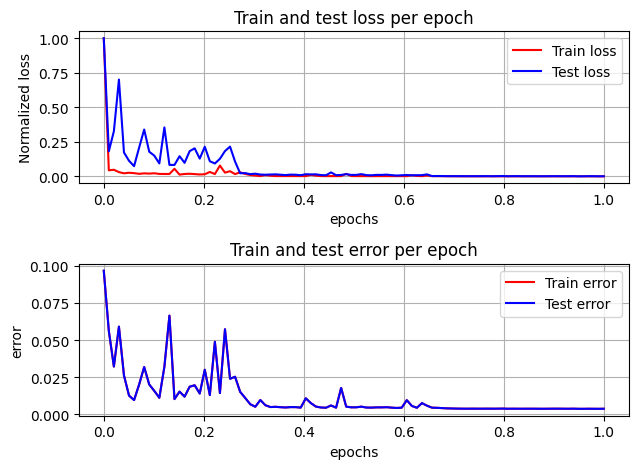

In [ ]:
# Instantiate the model
model_5 = ReLUModel(input_size=input_len, output_size=output_len, hidden_units= 64)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_5.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

train_loss, test_loss, train_err, test_err = train_test_model(epoch = 100,model = model_5, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(train_loss, test_loss,train_err,test_err)

relu_model_64 = eval_model(model_5, test_loader, loss_fn, device,True)
save_model_info(model_5,os.path.join(new_folder_path,relu_model_64["model_name"]))

In [164]:
relu_model_256, relu_model_64, relu_model

({'model_name': 'ReLUModel', 'model_loss': 0.003962622955441475},
 {'model_name': 'ReLUModel', 'model_loss': 0.0038998776581138372},
 {'model_name': 'ReLUModel', 'model_loss': 0.004468351602554321})

Η καλύτερη περίπτωση φαίνεται να είναι με 64 ```hidden_units```, αλλά για την ώρα κρατάμε τα 128

***

### Αρχιτεκτονική 2.1

#### LeakyRELU

Για την συγκεκριμένη αρχιτεκτονική και τα συγκεκριμένα ```hidden_units``` θα μελετήσουμε την διαφορά που προκαλούν διάφορες συναρτήσεις ενεργοποίησης.

Αρχικά μελετάμε την LeakyReLU, με τύπο:

$LeakyReLU(x) = max(0,x) + negative\_slope * min(0,x)$

In [165]:
class LeakyReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 1.0158650185242295 | Loss test: 0.09462882531067682 | lr = 0.01
Epoch 10 | Loss train: 0.025123546475544573 | Loss test: 0.03626638287234874 | lr = 0.01
Epoch 20 | Loss train: 0.0515317942854017 | Loss test: 0.017116634929109188 | lr = 0.01
Epoch 30 | Loss train: 0.00587533412873745 | Loss test: 0.004854219355842187 | lr = 0.001
Epoch 40 | Loss train: 0.005489698840305209 | Loss test: 0.004595858481017843 | lr = 0.001
Epoch 50 | Loss train: 0.004002767916768789 | Loss test: 0.003999772355965678 | lr = 0.0001
Epoch 60 | Loss train: 0.0038014454767107964 | Loss test: 0.0036969463366808165 | lr = 0.0001
Epoch 70 | Loss train: 0.0036727333907037975 | Loss test: 0.003636180500810345 | lr = 0.0001
Epoch 80 | Loss train: 0.003635969057213515 | Loss test: 0.003538058647545912 | lr = 0.0001
Epoch 90 | Loss train: 0.0035413896506652238 | Loss test: 0.0036270187498765095 | lr = 0.0001
Epoch 100 | Loss train: 0.003521294099278748 | Loss test: 0.0034905385118835265 | lr = 0.00

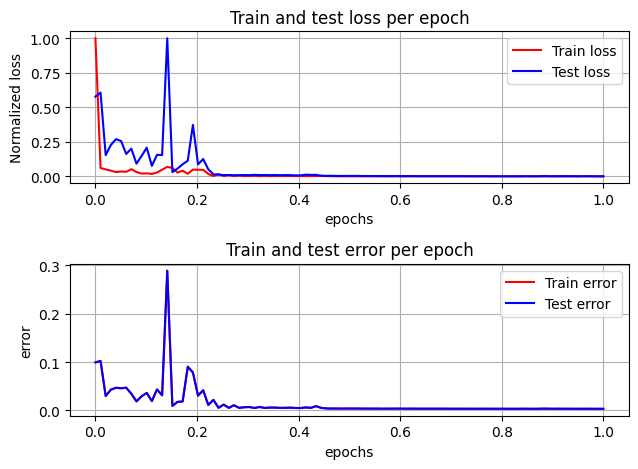

In [ ]:
# Instantiate the model
model_6 = LeakyReLUModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_6.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
train_loss, test_loss, train_err, test_err = train_test_model(epoch = 100,model = model_6, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(train_loss, test_loss,train_err,test_err)

leakyrelu = eval_model(model_6, test_loader, loss_fn, device,True)
save_model_info(model_6,os.path.join(new_folder_path,leakyrelu["model_name"]))

#### Tanh

Δοκιμάζουμε την συνάρτηση ενεργοποίησης tanh. 

$tanh(x) = \frac{exp(x) - exp(-x)}{exp(x) + exp(-x)}$

In [167]:
class tanhModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(tanhModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.4694610548913479 | Loss test: 0.17695501671423988 | lr = 0.01
Epoch 10 | Loss train: 0.12398872463405132 | Loss test: 0.15563033946922847 | lr = 0.01
Epoch 20 | Loss train: 0.12816449542343616 | Loss test: 0.14601788693477238 | lr = 0.01
Epoch 30 | Loss train: 0.13184736496210098 | Loss test: 0.10419116192866885 | lr = 0.01
Epoch 40 | Loss train: 0.1351759302020073 | Loss test: 0.08323796566516634 | lr = 0.01
Epoch 50 | Loss train: 0.13435309171676635 | Loss test: 0.10813725077443653 | lr = 0.01
Epoch 60 | Loss train: 0.04798115076869726 | Loss test: 0.04699754531657885 | lr = 0.001
Epoch 70 | Loss train: 0.042128396175801754 | Loss test: 0.04579567548538011 | lr = 0.001
Epoch 80 | Loss train: 0.038619675479829314 | Loss test: 0.04046060103509161 | lr = 0.001
Epoch 90 | Loss train: 0.03945233575999737 | Loss test: 0.039192385823717195 | lr = 0.001
Epoch 100 | Loss train: 0.03740868160128594 | Loss test: 0.04125364686525057 | lr = 0.001


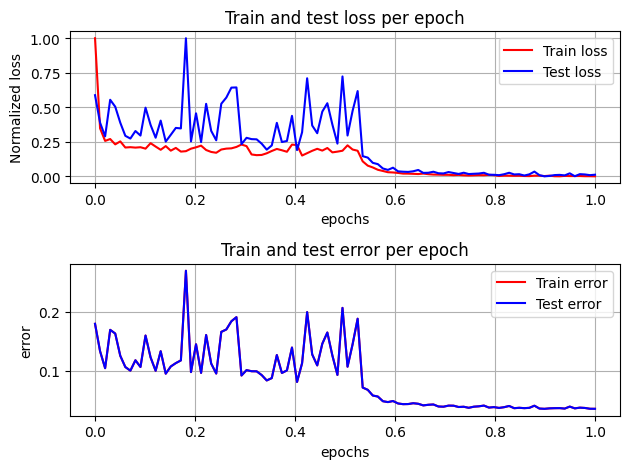

In [ ]:
# Instantiate the model
model_8 = tanhModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_8.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
train_loss, test_loss, train_err, test_err = train_test_model(epoch = 100,model = model_8, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(train_loss, test_loss,train_err,test_err)

tanh_model = eval_model(model_8, test_loader, loss_fn, device,True)
save_model_info(model_8,os.path.join(new_folder_path,tanh_model["model_name"]))

#### Sigmoid

$Sigmoid(x) = \frac{1}{1+exp(-x)}$

In [169]:
class sigmoidModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(sigmoidModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.206799655854702 | Loss test: 0.09901090486655159 | lr = 0.01
Epoch 10 | Loss train: 0.04036371204257012 | Loss test: 0.03333176944463972 | lr = 0.01
Epoch 20 | Loss train: 0.03395323165878653 | Loss test: 0.03384992063400291 | lr = 0.01
Epoch 30 | Loss train: 0.02828785103932023 | Loss test: 0.023116137699357102 | lr = 0.01
Epoch 40 | Loss train: 0.025308829475194215 | Loss test: 0.01745109302952649 | lr = 0.01
Epoch 50 | Loss train: 0.010343426221981644 | Loss test: 0.010797585685929608 | lr = 0.001
Epoch 60 | Loss train: 0.009051448669284583 | Loss test: 0.009449476716182535 | lr = 0.001
Epoch 70 | Loss train: 0.008314421171322466 | Loss test: 0.008894257801806643 | lr = 0.001
Epoch 80 | Loss train: 0.007973940223455428 | Loss test: 0.008964335043278952 | lr = 0.001
Epoch 90 | Loss train: 0.007548097021877765 | Loss test: 0.008719899898601903 | lr = 0.001
Epoch 100 | Loss train: 0.007175284894183278 | Loss test: 0.008141497150063515 | lr = 0.001


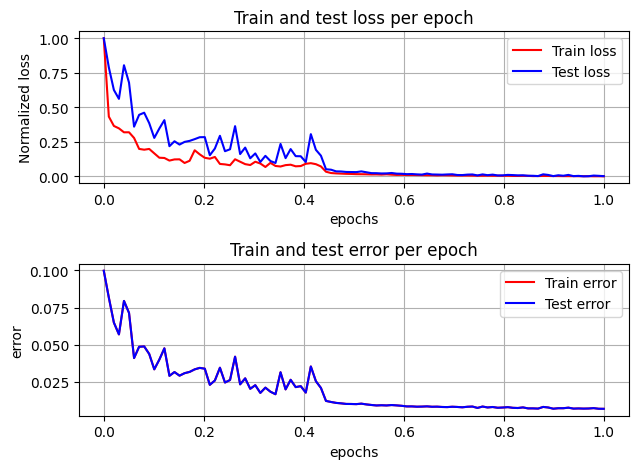

In [ ]:
# Instantiate the model
model_9 = sigmoidModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_9.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
train_loss, test_loss, train_err, test_err = train_test_model(epoch = 100,model = model_9, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(train_loss, test_loss,train_err,test_err)

sigmoid_model = eval_model(model_9, test_loader, loss_fn, device, True)
save_model_info(model_9,os.path.join(new_folder_path,sigmoid_model["model_name"]))

### Αρχιτεκτονική 3

Μιας και βλέπουμε ότι τα καλύτερα αποτελέσματα τα δίνει το μοντέλο με συνάρτηση ενεργοποίησης LeakyReLU , θα δοκιμάσουμε να βάλουμε άλλο ένα layer για να δούμε πως θα επηρεαστουν τα αποτελέσματα.

In [171]:
class LeakyReLUModel4(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModel4, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.9869200924113393 | Loss test: 0.09307776178632464 | lr = 0.01
Epoch 10 | Loss train: 0.08910267698206008 | Loss test: 0.010555168791186242 | lr = 0.01
Epoch 20 | Loss train: 0.05009545102808625 | Loss test: 0.019686131812040767 | lr = 0.01
Epoch 30 | Loss train: 0.006084121264517307 | Loss test: 0.005286854669629108 | lr = 0.001
Epoch 40 | Loss train: 0.0045800873772241174 | Loss test: 0.004200969981620946 | lr = 0.001
Epoch 50 | Loss train: 0.004687611676286906 | Loss test: 0.00457772392306536 | lr = 0.001
Epoch 60 | Loss train: 0.003586396192666143 | Loss test: 0.0035704909232518976 | lr = 0.0001
Epoch 70 | Loss train: 0.0034795918380841613 | Loss test: 0.003527972775156654 | lr = 0.0001
Epoch 80 | Loss train: 0.003413299012929201 | Loss test: 0.0035675570852906693 | lr = 0.0001
Epoch 90 | Loss train: 0.003370109866373241 | Loss test: 0.003580689587305108 | lr = 0.0001
Epoch 100 | Loss train: 0.0033293382888659835 | Loss test: 0.003442691457975242 | lr = 0.000

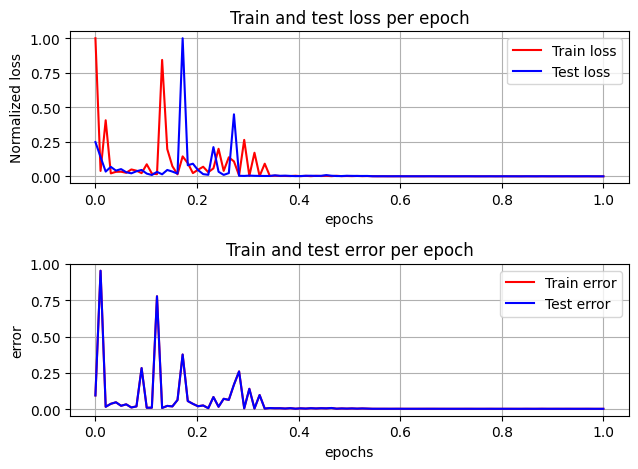

In [ ]:
# Instantiate the model
model_10 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_10.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
train_loss, test_loss, train_err, test_err = train_test_model(epoch = 100,model = model_10, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(train_loss, test_loss,train_err,test_err)

leakyrelu_4 = eval_model(model_10, test_loader, loss_fn, device,True)
save_model_info(model_10,os.path.join(new_folder_path,leakyrelu_4["model_name"]))

Παρατηρούμε ότι η επίδοση του μοντέλου δεν καλυτέρεψε, άρα δεν χρειάζεται να προσθέσουμε και άλλα layers.

### Αρχιτεκτονική 4

#### Dropout

Θα προσθέσουμε ένα άλλο επίπεδο που συνίσταται σε μοντέλα με μικρά datasets, το ```Dropout```. Αυτό, με πιθανότητα p "νεκρώνει" έναν νευρώνα, βοηθώντας έτσι το μοντέλο να κατανοήσει γενικότερα συμπεράσματα για τα δεδομένα που του δίνουμε.

In [173]:
class LeakyReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 1.067916772276163 | Loss test: 0.2830096573110611 | lr = 0.01
Epoch 10 | Loss train: 0.13568773441016674 | Loss test: 0.0718483722044362 | lr = 0.01
Epoch 20 | Loss train: 0.15824689263105393 | Loss test: 0.07480444930612094 | lr = 0.001
Epoch 30 | Loss train: 0.019810868669301273 | Loss test: 0.015239207295789606 | lr = 0.001
Epoch 40 | Loss train: 0.016279305346310138 | Loss test: 0.017198173403148612 | lr = 0.001
Epoch 50 | Loss train: 0.014905954897403716 | Loss test: 0.018179588625946687 | lr = 0.001
Epoch 60 | Loss train: 0.015067977955564856 | Loss test: 0.020622229247930505 | lr = 0.001
Epoch 70 | Loss train: 0.015680655999109148 | Loss test: 0.02154612418500677 | lr = 0.001
Epoch 80 | Loss train: 0.01412233879044652 | Loss test: 0.02294040085481746 | lr = 0.001
Epoch 90 | Loss train: 0.014465027594938874 | Loss test: 0.02084331830874795 | lr = 0.0001
Epoch 100 | Loss train: 0.009358810044825076 | Loss test: 0.020616223769528524 | lr = 0.0001


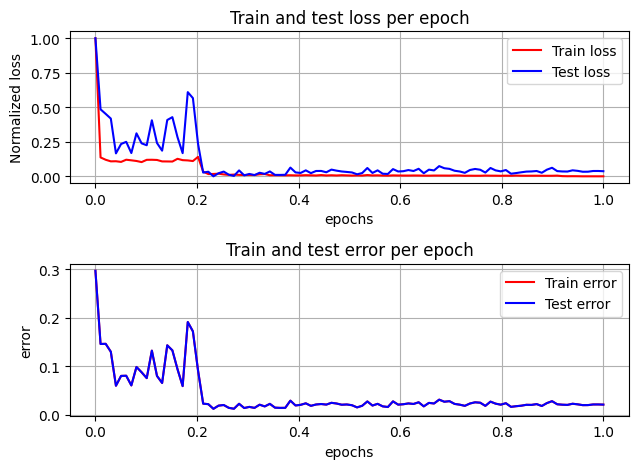

In [ ]:
# Instantiate the model
model_11 = LeakyReLUModelDropout(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_11.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
train_loss, test_loss, train_err, test_err = train_test_model(epoch = 100,model = model_11, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(train_loss, test_loss,train_err,test_err)

dropout_model = eval_model(model_11, test_loader, loss_fn, device,True)
save_model_info(model_11,os.path.join(new_folder_path,dropout_model["model_name"]))

### Αρχιτεκτονική 5

#### XGB

Θα χρησιμοποιήσουμε και τον γνωστό αλγόριθμο για regression XGB, με την βοήθεια του MultiOutputRegressor.

In [175]:
X = info_tensor.reshape(len(info_tensor), -1)
y = rfid_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [176]:
xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=1500, learning_rate=0.01, eta = 0.2, tree_method = 'hist', device = 'cuda')

# Fit the model
multi_xgb = MultiOutputRegressor(xgb_model)
multi_xgb.fit(X_train_scaled, y_train) 

# Predict the model
y_pred = multi_xgb.predict(X_test_scaled)

xgb_loss = mean_squared_error(y_test, y_pred)

xgb_res = {'model_name': 'xgb_model', 'model_loss' : xgb_loss}

c:\Users\giama\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:17:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\giama\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:17:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\giama\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:20:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warni

### Αρχιτεκτονική 6

#### Epochs

Θα δοκιμάσουμε επίσης αντί να δημιουργούμε batches να περνάμε τα data απευθείας στο μοντέλο.

Για την δοκιμή αυτή θα χρησιμοποιήσουμε το μοντέλο LeakyReLUModel4 με συνάρτηση ενεργοποίησης την LeakyReLU και 4 επίπεδα.

Δεν δημιουργώ συναρτήσεις αφού είναι μεμονομένη περίπτωση.

In [177]:
# Instantiate the model
model_13 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_13.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [178]:
X = info_tensor.reshape(len(info_tensor), -1)
y = rfid_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Set seed before defining model and optimizer
torch.manual_seed(42)  

# Move model to device **before** training
model_13.to(device)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

# Set number of epochs
epochs = 1000  

# Training loop
for epoch in range(epochs):
    model_13.train()
    
    # Forward pass
    y_pred = model_13(X_train_tensor)

    # Compute loss
    loss = loss_fn(y_pred, y_train_tensor)  

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    model_13.eval()
    with torch.inference_mode():
        test_logits = model_13(X_test_tensor)
        test_loss = loss_fn(test_logits, y_test_tensor).detach()  # Ensure no gradients


    # Update learning rate scheduler
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(test_loss.detach())  
    else:
        scheduler.step()

    # Print every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")
print(f"Epoch: {epoch + 1} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

epoch_res = {'model_name': 'LeakyReLU4_noBatches', 'model_loss' : test_loss.cpu().item()}
save_model_info(model_13,os.path.join(new_folder_path,epoch_res["model_name"]))

Epoch: 0 | Train Loss: 2.09935 | Test Loss: 6.46282
Epoch: 100 | Train Loss: 0.40159 | Test Loss: 0.39571
Epoch: 200 | Train Loss: 0.40051 | Test Loss: 0.39483
Epoch: 300 | Train Loss: 0.40048 | Test Loss: 0.39480
Epoch: 400 | Train Loss: 0.40044 | Test Loss: 0.39476
Epoch: 500 | Train Loss: 0.40040 | Test Loss: 0.39471
Epoch: 600 | Train Loss: 0.40035 | Test Loss: 0.39466
Epoch: 700 | Train Loss: 0.40030 | Test Loss: 0.39461
Epoch: 800 | Train Loss: 0.40025 | Test Loss: 0.39455
Epoch: 900 | Train Loss: 0.40019 | Test Loss: 0.39449
Epoch: 1000 | Train Loss: 0.40013 | Test Loss: 0.39443


## Results

In [180]:
compare_results = pd.DataFrame([leakyrelu, leakyrelu_4, relu_model,dropout_model, sigmoid_model, tanh_model])
compare_results = compare_results._append(xgb_res, ignore_index = True)
compare_results = compare_results._append(epoch_res, ignore_index = True)
compare_results.sort_values(by = 'model_loss', ascending= True, inplace= True)
compare_results

,model_name,model_loss
1,LeakyReLUModel4,0.003443
0,LeakyReLUModel,0.003491
2,ReLUModel,0.004468
6,xgb_model,0.006250
4,sigmoidModel,0.008141
3,LeakyReLUModelDropout,0.020616
5,tanhModel,0.041254
7,LeakyReLU4_noBatches,0.394434


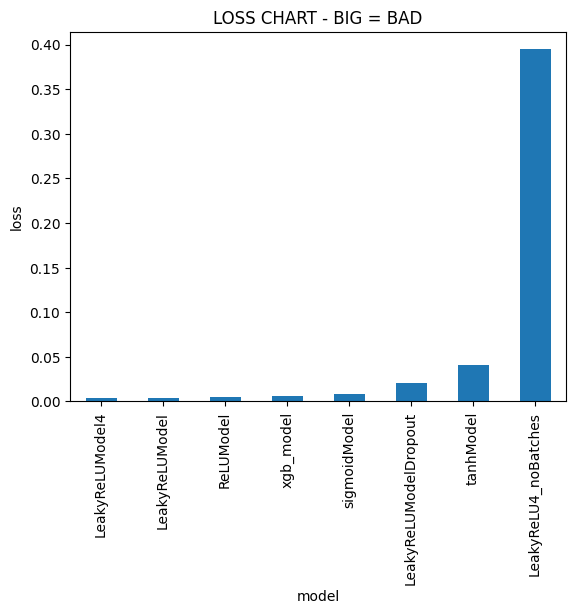

In [181]:
# Visualize our model results
compare_results.set_index("model_name")["model_loss"].plot(kind="bar")
plt.xlabel("model")
plt.ylabel("loss")
plt.title("LOSS CHART - BIG = BAD")
plt.show()

***